## Packages

In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dense, SimpleRNN, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

## Data Pre-processing

In [120]:
df = pd.read_csv('2018-2019_bit.csv')
df = df.iloc[:,1:]
df.columns = ['date', 'open', 'high', 'low', 'close', 'vol(btc)', 'vol', 'weighted_price']
df['date'] = pd.to_datetime(df['date'])
df.index = pd.to_datetime(df['date'])
df.drop(["date", "vol(btc)", 'weighted_price'], axis=1, inplace=True)
df

,open,high,low,close,vol
date,,,,,
2018-09-25 00:01:00,6598.88,6601.91,6598.88,6601.75,115553.481670
2018-09-25 00:02:00,6600.02,6601.17,6600.00,6601.17,4128.483922
2018-09-25 00:03:00,6601.89,6602.01,6601.32,6602.00,44318.766584
2018-09-25 00:04:00,6602.65,6604.96,6602.00,6602.00,33180.213169
2018-09-25 00:05:00,6607.51,6607.82,6606.24,6606.88,16551.781741
...,...,...,...,...,...
2019-01-01 23:55:00,3680.50,3680.50,3680.44,3680.44,6378.448310
2019-01-01 23:56:00,3681.29,3682.72,3681.29,3681.59,19499.287664
2019-01-01 23:57:00,3677.63,3677.63,3677.63,3677.63,365.924185


In [121]:
# Prepare the volume and price differences, normalize volume
BTC_vol = df["vol"].values
df_diff = df.diff().dropna() # difference of df
df_diff["vol"] = np.log(1 + BTC_vol[:-1])  # Shifted by 1 to align with diff
df_aligned = df.loc[df_diff.index]
mask_train = (df_diff.index >= "2018-10-01") & (df_diff.index < "2018-12-31")
df_train = df_diff.loc[mask_train].copy()
# Use df_aligned to ensure the indexes match
train_close = df_aligned.loc[mask_train, "close"].values

# Since indexes are aligned, this operation should now work without error
df_train["Relative_Close"] = train_close / train_close[0]

df_train

,open,high,low,close,vol,Relative_Close
date,,,,,,
2018-10-01 00:00:00,-3.05,-1.58,0.05,0.05,9.311424,1.000000
2018-10-01 00:01:00,-0.52,-1.99,-2.89,-2.89,9.206623,0.999560
2018-10-01 00:02:00,-4.96,-4.96,-6.67,-3.92,10.174242,0.998963
2018-10-01 00:03:00,-3.30,-3.30,0.04,-0.02,9.247930,0.998960
2018-10-01 00:04:00,0.04,1.55,2.73,1.13,8.408290,0.999132
...,...,...,...,...,...,...
2018-12-30 23:55:00,-1.25,-1.25,-4.57,-3.89,6.418919,0.579548
2018-12-30 23:56:00,-6.00,-6.00,-2.68,-3.36,9.618290,0.579037
2018-12-30 23:57:00,2.25,2.25,2.25,2.25,5.989581,0.579379


In [122]:
mask_test = (df_diff.index >= "2018-12-31") & (df_diff.index < "2019-01-01")  # December 2018 for testing
df_test = df_diff.loc[mask_test].copy()
test_close = df_aligned.loc[mask_test, "close"].values
df_test["Relative_Close"] = test_close / train_close[0]
df_test

,open,high,low,close,vol,Relative_Close
date,,,,,,
2018-12-31 00:00:00,-1.94,3.06,-1.65,3.90,10.378692,0.579045
2018-12-31 00:01:00,3.43,1.50,5.08,2.60,10.368279,0.579440
2018-12-31 00:02:00,2.81,-0.26,2.81,-0.26,4.599903,0.579401
2018-12-31 00:03:00,-0.17,0.25,-1.23,-1.23,7.900077,0.579214
2018-12-31 00:04:00,-0.50,-0.92,-2.97,0.56,8.638780,0.579299
...,...,...,...,...,...,...
2018-12-31 23:55:00,5.14,6.94,5.14,6.34,8.238887,0.573903
2018-12-31 23:56:00,-0.68,-2.48,-0.68,-1.88,7.090026,0.573617
2018-12-31 23:57:00,2.22,2.22,2.22,2.22,8.551954,0.573955


### Generate LSTM Dataset 

In [123]:
# Generate dataset function for LSTM
def generate_dataset_LSTM(df, seq_len):
    X_list, y_list = [], []
    for i in range(len(df) - seq_len):
        X_list.append(df.iloc[i:(i+seq_len), :].values)
        y_list.append(df["close"].iloc[i + seq_len])
    return np.array(X_list), np.array(y_list)

In [124]:
LAG = 5 # Example: Use the past # days to predict the next day
# Prepare training and test datasets
X_train_LSTM, y_train_LSTM = generate_dataset_LSTM(df_train, LAG)
X_test_LSTM, y_test_LSTM = generate_dataset_LSTM(pd.concat((df_train.iloc[-LAG:], df_test)), LAG)

In [125]:
X_train_LSTM.shape

(131035, 5, 6)

## LSTM (unchanged from minute-by-minute example)

In [126]:
# model architecture
tf.keras.utils.set_random_seed(4012)
model = Sequential([
    LSTM(8, return_sequences=True, input_shape=(X_train_LSTM.shape[1], X_train_LSTM.shape[2])),
    LSTM(8, dropout=0.2),
    Dense(1)
])
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

# train the dataset
model.fit(X_train, y_train, batch_size=64, epochs=30, shuffle=True) 

Epoch 1/30


c:\Users\user\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2048/2048 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - loss: 25.9587
Epoch 2/30
2048/2048 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 25.8830
Epoch 3/30
2048/2048 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 25.8297
Epoch 4/30
2048/2048 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 25.7959
Epoch 5/30
2048/2048 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 25.7795
Epoch 6/30
2048/2048 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 25.7602
Epoch 7/30
2048/2048 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 25.7377
Epoch 8/30
2048/2048 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 25.7495
Epoch 9/30
2048/2048 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 25.7365
Epoch 10/30
2048/2048 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 25.7115
Epoch 11/30
2048/2048 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 25.6948
Epoch 12/30
2048/2048 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 25.6710
Epoch 13/30
2048/2048 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 25.6782
Epoch 14/30
2048/2048 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 25.6755
Epoch 15/30
2048/2048 ━━━━

In [127]:
# Predict and evaluate
pred_LSTM = np.squeeze(model.predict(X_test_LSTM))
print("Test MSE:", np.mean((pred_LSTM - y_test_LSTM)**2))

45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 661us/step
Test MSE: 16.522576491636364


In [128]:
pred_LSTM, y_test_LSTM

(array([-0.09938113, -0.71711093, -0.6029863 , ...,  0.3120924 ,
         0.06959172, -0.16196993], dtype=float32),
 array([ 3.9 ,  2.6 , -0.26, ...,  2.22,  0.19,  1.44]))

## MLP

In [129]:
X_train_MLP = df_train[['open'	,'high'	,'low'	,'vol',	'Relative_Close']]
y_train_MLP = df_train[['close']]
X_test_MLP = df_test[['open'	,'high'	,'low'	,'vol',	'Relative_Close']]
y_test_MLP = df_test[['close']]

In [130]:
# # Min-Max Scaling
# scaler = MinMaxScaler()
# data_train = scaler.fit_transform(df_train[['open','high'	,'low'	,'vol',	'Relative_Close', 'close']])
# data_test = scaler.fit_transform(df_test[['open','high','low'	,'vol',	'Relative_Close', 'close']])
# df_train_MLP = pd.DataFrame(data_train, columns=['open','high','low'	,'vol',	'Relative_Close', 'close'], index=df_train.index)
# df_test_MLP = pd.DataFrame(data_test, columns=['open','high','low'	,'vol',	'Relative_Close', 'close'], index=df_test.index)

In [131]:
# X_train_MLP = df_train_MLP[['open'	,'high'	,'low'	,'vol',	'Relative_Close']]
# y_train_MLP = df_train_MLP[['close']]
# X_test_MLP = df_test_MLP[['open','high'	,'low'	,'vol',	'Relative_Close']]
# y_test_MLP = df_test_MLP[['close']]

In [132]:
X_train_MLP.shape

(131040, 5)

In [133]:
# model architecture for MLP: 1 64-nueron layer and 1 Dropout
tf.keras.utils.set_random_seed(4012)
model2 = Sequential()
model2.add(tf.keras.Input(shape=(X_train_MLP.shape[1],))) # input features
model2.add(Dense(64, activation='relu'))
model2.add(Dropout(0.5))
model2.add(Dense(1))

model2.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
model2.fit(X_train_MLP, y_train_MLP, batch_size=64, epochs=100, shuffle=True)

Epoch 1/100


2048/2048 ━━━━━━━━━━━━━━━━━━━━ 1s 376us/step - loss: 13.5241
Epoch 2/100
2048/2048 ━━━━━━━━━━━━━━━━━━━━ 1s 367us/step - loss: 8.7015
Epoch 3/100
2048/2048 ━━━━━━━━━━━━━━━━━━━━ 1s 371us/step - loss: 8.3679
Epoch 4/100
2048/2048 ━━━━━━━━━━━━━━━━━━━━ 1s 375us/step - loss: 8.4310
Epoch 5/100
2048/2048 ━━━━━━━━━━━━━━━━━━━━ 1s 395us/step - loss: 8.3941
Epoch 6/100
2048/2048 ━━━━━━━━━━━━━━━━━━━━ 1s 404us/step - loss: 8.3794
Epoch 7/100
2048/2048 ━━━━━━━━━━━━━━━━━━━━ 1s 395us/step - loss: 8.2099
Epoch 8/100
2048/2048 ━━━━━━━━━━━━━━━━━━━━ 1s 404us/step - loss: 8.4128
Epoch 9/100
2048/2048 ━━━━━━━━━━━━━━━━━━━━ 1s 416us/step - loss: 8.3074
Epoch 10/100
2048/2048 ━━━━━━━━━━━━━━━━━━━━ 1s 368us/step - loss: 8.3599
Epoch 11/100
2048/2048 ━━━━━━━━━━━━━━━━━━━━ 1s 390us/step - loss: 8.2529
Epoch 12/100
2048/2048 ━━━━━━━━━━━━━━━━━━━━ 1s 375us/step - loss: 8.2868
Epoch 13/100
2048/2048 ━━━━━━━━━━━━━━━━━━━━ 1s 367us/step - loss: 8.3330
Epoch 14/100
2048/2048 ━━━━━━━━━━━━━━━━━━━━ 1s 379us/step - loss: 8.371

In [134]:
pred_MLP = model2.predict(X_test_MLP)
pred_MLP

45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 459us/step


array([[2.532686  ],
       [1.9043002 ],
       [0.1795718 ],
       ...,
       [2.0005984 ],
       [0.27587014],
       [1.4873893 ]], dtype=float32)

In [135]:
# # Model Pred rescale
# scaled_pred_MLP = model2.predict(X_test_MLP)
# scaled_pred_MLP_reshaped = np.zeros((scaled_pred_MLP.shape[0], df_test.shape[1]))
# scaled_pred_MLP_reshaped[:, 0] = scaled_pred_MLP[:, 0]  # Assuming the first column is the predicted closing price
# pred_MLP_reshaped = scaler.inverse_transform(scaled_pred_MLP_reshaped) # Apply inverse transformation
# pred_MLP = pred_MLP_reshaped[:, 0]
# pred_MLP

In [136]:
# # y_test_MLP rescale
# scaled_actual_MLP_reshaped = np.zeros((scaled_pred_MLP.shape[0], df_test.shape[1]))
# scaled_actual_MLP_reshaped[:, 0] = y_test_MLP['close']  # Assuming the first column is the predicted closing price
# actual_MLP_reshaped = scaler.inverse_transform(scaled_actual_MLP_reshaped) # Apply inverse transformation
# actual_MLP = actual_MLP_reshaped[:, 0]
# actual_MLP

In [137]:
mse = tf.keras.losses.MeanSquaredError()
mse_MLP = mse(y_test_MLP, pred_MLP)
mse_LSTM = mse(y_test_LSTM, pred_LSTM)
mse_MLP, mse_LSTM

(<tf.Tensor: shape=(), dtype=float32, numpy=3.820347>,
 <tf.Tensor: shape=(), dtype=float32, numpy=16.522577>)

In [138]:
np.array(df_test.index)

array(['2018-12-31T00:00:00.000000000', '2018-12-31T00:01:00.000000000',
       '2018-12-31T00:02:00.000000000', ...,
       '2018-12-31T23:57:00.000000000', '2018-12-31T23:58:00.000000000',
       '2018-12-31T23:59:00.000000000'], dtype='datetime64[ns]')

Text(0, 0.5, 'Price')

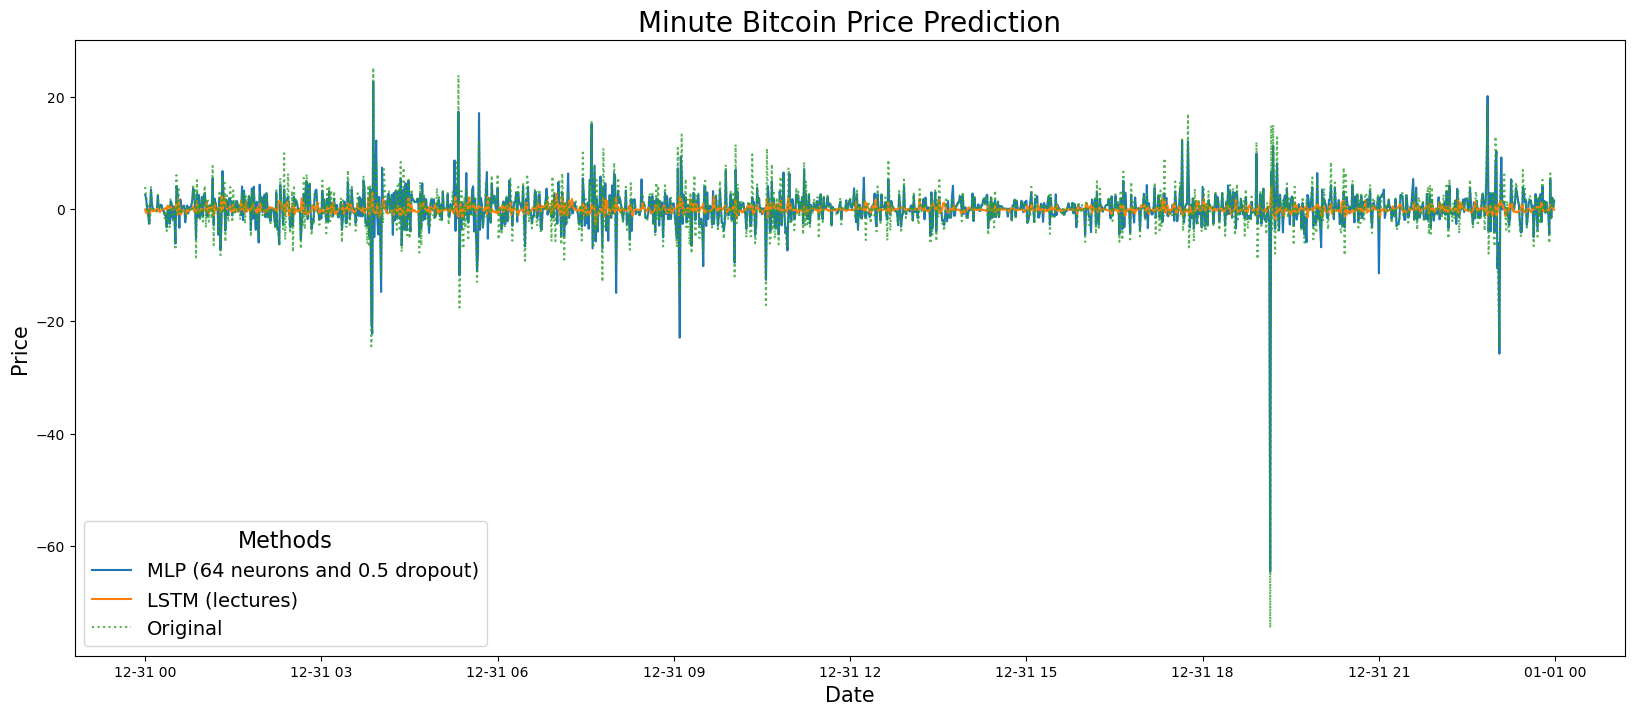

In [139]:
fig = plt.figure(figsize=(20,8))
plt.plot(np.array(df_test.index), pred_MLP, label='MLP (64 neurons and 0.5 dropout)')
plt.plot(np.array(df_test.index), pred_LSTM, label='LSTM (lectures)')
plt.plot(np.array(df_test.index), df_test["close"], label='Original', linestyle='dotted', alpha=0.8)
plt.legend(title='Methods',title_fontsize=16, fontsize=14)
plt.title('Minute Bitcoin Price Prediction', fontsize=20)
plt.xlabel('Date', fontsize=15)
plt.ylabel('Price', fontsize=15)